# Python Simple Text Classification
***Note - There is a lot of formatting stuff going on in some of the markdown cells. Alot of them do not render and will not display at all if you read this on github. Instead pull down the repo and open it as a jupyter notebook ***

This tutorial is meant to help get started on a text classification problem using python. It is recommended to retype out all of the code in a sepearte notebook to try and understan each section as it goes. Individual sections can be accessed from links at the top. Links to additional reading on different conecpts presented here can be found in the additional resources section at the end of the notebook. 

### Goal
Given a set of business descriptions can we create a model to identify whehther it is construction business or a non construction business

### Areas Covered
 - [Reading in Data](#data_reading)
 - [Exploring the Data](#data_explore)
 - [Understanding How to Transform Text Data](#how_to_data_transform)
 - [Transforming Data](#data_transform)
 - [Training a Simple Model](#model_train)
 - [Evaluating a Model](#model_evaluate)
 - [Overfitting & Bias Variance Tradeoff](#overfitting)
 - [Writing Proper Kaggle Submission](#kaggle_submission)
 - [What to do next](#next)
 - [Additional Resources](#additional_resources)

### Setting up the notebook

In [2]:
# Import the some stuff we need, others imported as needed througout
import pickle                    # pythons version of serialization
import warnings                  # control what warnings are displayed

import pandas as pd              # tabular data tables
import matplotlib.pyplot as plt  # simple visualizations
import seaborn as sns            # built on top of matplotlib, maybe better depending on preference
import numpy as np               # any dimensional arrays functions/classes

In [3]:
# Make some changes to notebook set-up
# make plots display in the notebook
%matplotlib inline
warnings.filterwarnings('ignore')     # warnings are ulgy, we can live without them

In [4]:
# Constant Declarations for this run
DATA_SET = "data/sample_training_descs.pkl"      # Link at end if you want to know about pickles
RANDOM_SEED = 523                                # Make randomness reproducible

<a id='data_reading'></a>
## Reading in the Data

In [5]:
# Read in some example data to a dataframe
with open(DATA_SET, 'rb') as in_pickle:          # Link at end for info on context managers
    data_df = pickle.load(in_pickle)             # Link at end to learn about dataframes

# What does our dataframe look like
data_df.head()

,id,bus_seq_num,target,desc,industry_group_id,construction_flag
0,1000,1.0,0913,livestock operations,01,0
1,10000,1.0,9082,restaurant,36,0
2,1000004,1.0,5537,northern colorado air inc. and northern colora...,27,1
3,1000008,1.0,9083,fast-food chain serving chicken wings and fing...,36,0
4,1000009,1.0,9082,quay's restaurant group llc dba darcy's bistro...,36,0


In [6]:
# More info about this dataframe
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
id                   10000 non-null object
bus_seq_num          10000 non-null float64
target               10000 non-null object
desc                 10000 non-null object
industry_group_id    10000 non-null object
construction_flag    10000 non-null object
dtypes: float64(1), object(5)
memory usage: 468.8+ KB


<span style="color:green"><font size=4>Isn't this nice? Usually we will not be so lucky with any sort of data science project and there will be nulls, missing values, and many features and just some general garbage. In some cases like text classification this might not be the case though and we can skip the entire process of data munging and data cleaning. There will still be many options for data transformations, but at least we are starting from a nice clean point</font></span>

<a id='data_explore'></a>
## Exploring the data
<span style="color:green"><font size=4>Before jumping in on any data transformations or machine learning it is a good idea to take a look at the data. This will give us an idea of what kind of transofmations are needed and what kind of algorithms may work best. Although time consuming it can be beneficial down the road to understand what kind of data you are working with.</font></span>

#### Take a look at a few descriptions

In [7]:
# Additional resources has a link to decent python string formatting walthrough
max_characters = 500
print(f"Descriptions - first {max_characters} characters\n")
for _, row in data_df.iloc[:5].iterrows():
    print(f"TARGET: {row['target']} or {row['construction_flag']}\nDESCR: {row['desc'].strip()[:max_characters]}\n")

Descriptions - first 500 characters

TARGET: 0913 or 0
DESCR: livestock operations

TARGET: 9082 or 0
DESCR: restaurant

TARGET: 5537 or 1
DESCR: northern colorado air inc. and northern colorado air of longmont inc. is a hvac contractor in norther colorado.  insured has two locations:  fort collins and sales office in longmont.   insured offers installation, repairs of hvac systems, preventative planned maintenance, and sheet metal fabrication.  insured does residential and light commercial.   

employees will do service calls, replacements, new construction (1111); administrative employees who handle calls, general manager, administrativ

TARGET: 9083 or 0
DESCR: fast-food chain serving chicken wings and fingers, plus burgers, chili and sides

TARGET: 9082 or 0
DESCR: quay's restaurant group llc dba darcy's bistro and pub is a sit down restaurant serving appetizers, alcohol and food.  

full service restaurant.  duties include:  food preparation, order taking, food running, dishwashin

<span style="color:green"><font size=4>Things worth noting
* Our predictive feature in this case are text strings  
* This needs to be transformed for any machine learning algorithms  
* These strings are of very different lengths
* The text could use some cleaning things like , ' : - . ) etc....
* Also worth noting how jargony these descriptions are</font></span>

<span style="color:green"><font size=4>
All of these things can be taken care, and we will walk through how to handle them as we work on the data transformation section
</font></span>

##### How long are these descriptions?

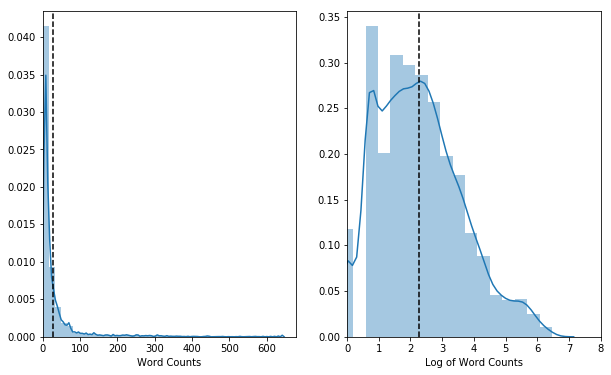

In [8]:
# Graph of log counts and total counts for all descritpions
fig, ax = plt.subplots(1, 2, figsize=(10,6))                            # Make an empty figure we can control
word_counts = data_df['desc'].apply(lambda x: len(x.split()))           # Number of words in each description
log_counts = np.log(word_counts + 0.0001)                               # need small adjustments for any 0's

# Generate first subplot - total counts
sns.distplot(a=word_counts, bins=40, axlabel="Word Counts", ax=ax[0])
ax[0].axvline(x=np.average(word_counts), color='k', linestyle='--')

# Generate second subplot - log counts
sns.distplot(a=log_counts, bins=40, axlabel="Log of Word Counts", ax=ax[1])
ax[1].axvline(x=np.average(log_counts), color='k', linestyle='--')

# Clean these up a bit
ax[0].set_xlim(left=0)
ax[1].set_xlim(left=0);

##### Exercise 1: How many unique different words are we dealing with?
If you feel like trying to write some code then give the exercises throughout a go. Some of them might be harder than others, just do what seems interesting. They are not vital to the tutorial if you feel like skipping them. There are many ways to approach these, potential answers can be found at the end of the notebook


Fill in the below code to generate graphs like above
This does not have to be perfect, but feel free to try and remove punctuation and such to make it better

In [9]:
# See numbr of words (not perfect still has punctuation and stuff)
num_words = len(set(' '.join(data_df['desc']).split(' ')))
print(f"Total Non-Uqique Words {num_words:,}")

# Make a big string of all the descriptions
pass

# Make a list of all the words
pass

# Remove punctuation from all words
pass

# Get a count of all the unique words
from collections import Counter        # just an option to use, many other options
pass

# Examine counts, maybe plot like above if wanted
pass

Total Non-Uqique Words 25,438


#### Examine the target 
Here we are going to try and predict the binary category of construction vs. not construction so it is probably a good idea to take a quick and make sure this is balanced.

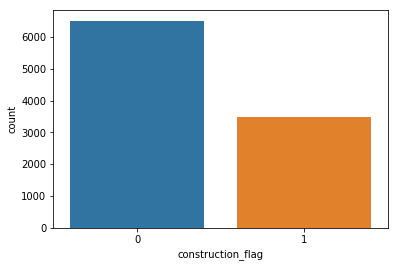

In [10]:
# Laziest way is utilize a prebuilt plot, could always build more graudually ourselves though
fig, ax = plt.subplots()
sns.countplot(data=data_df, x='construction_flag', ax=ax);

<span style="color:green"><font size=4>
Well, this is not balanced, but it is not terrible. There are ways to deal with. Could try to blance it and then train a model, or could train as is and give the different classes different weights, or could choose a metric during cross validation that helps with this. Could maybe do nothing since it is not too bad, but it is definitly good to keep in mind.  
    </span>

<a id='how_to_data_transform'></a>
## Understanding Text Data Transformation

<span style="color:green"><font size=4>For most python machine learning the algorithms will only accept numerical data. So something like "I am a landscaper" needs to be transformed. There are many options to transform this text into vectors, simple boolean ones, count ones, or a fairly standard tfidf (Term Frequency / Inverse Document Frequency). Lets walk through a very trivial creation of some simplified TFIDF vectors. Lets suppose we have 4 descriptions.</font></span> 

|Doc Number  |  raw descr                             |
|------------|----------------------------------------|
|1           | I walk dogs, and love dogs             |
|2           | I train dogs to talk :)                |
|3           | I am a dog catcher that cathes.        |
|4           | bread baker, and other baked goods     |

<span style="color:green"><font size=4>First we remove some useless words called "stop words", and get rid of any puntuation and could possibly remove plurals and maybe apply some stemming and lemming. Discussion of "stop words", and "stemming and lemming" can be found in the additional links section a the end. The choice to use lemming or stemming can be up to you as you approach the problem. For example if we were to turn all instances of goods into good would we lose meaning? Questions like this may depend on the domain we are working in or the size of the corpus we are dealing with</font></span> 

|Doc Number  |  raw descr                             | cleaner descr         |
|------------|----------------------------------------|-----------------------|
|1           | I walk dogs, and love dogs             | walk dog love dog     |
|2           | I train dogs to talk :)                | train dog talk        |
|3           | I am a dog catcher that catches.        | dog catch catch       |
|4           | bread baker, and other baked goods     | bread bake bake good  |

<span style="color:green"><font size=4>So now we need to get the term count of the each term, or how many times it appears in each document</font></span> 

|Doc Number  | ... | cleaner descr         | walk | dog | love | train | talk | catch | bread | bake |good |
|------------|-----|-----------------------|------|-----|------|-------|------|-------|-------|------|-----|
|1           | ... | walk dog love dog     | 1    | 2   | 1    | 0     | 0    | 0     | 0     | 0    |0    |
|2           | ... | train dog talk        | 0    | 1   | 0    | 1     | 1    | 0     | 0     | 0    |0    |
|3           | ... | dog catch catch       | 0    | 1   | 0    | 0     | 0    | 2     | 0     | 0    |0    |
|4           | ... | bread bake bake good  | 0    | 0   | 0    | 0     | 0    | 0     | 1     | 2    |1    |

<span style="color:green"><font size=4>Now to account for how important a word is to a document we need to account for the length of a documnet. If the word dog appears 2 times in a 15 word document it is probably very important. If it appears 2 times in a 15,000 word document it is probably less important. This is done simple by dividing the count by the total document length. So in the first document dog appears 2 times in a 4 word document. This will gives us the Term Frequency or TF, the first piece of the tf-idf.  
$$tf = \dfrac{wordCount}{documentLenth}$$  
$$tfDoc1Dog = \dfrac{2}{4} = 0.5$$
</font></span> 

|Doc Number  | ... | cleaner descr         | walk | dog | love | train | talk | catch | bread | bake |good |
|------------|-----|-----------------------|------|-----|------|-------|------|-------|-------|------|-----|
|1           | ... | walk dog love dog     | 0.25 | 0.5 | 0.25 | 0     | 0    | 0     | 0     | 0    |0    |
|2           | ... | train dog talk        | 0    | 0.33| 0    | 0.33  | 0.33 | 0     | 0     | 0    |0    |
|3           | ... | dog catch catch       | 0    | 0.33| 0    | 0     | 0    | 0.66  | 0     | 0    |0    |
|4           | ... | bread bake bake good  | 0    | 0   | 0    | 0     | 0    | 0     | 0.25  | 0.5  |0.25 |

<span style="color:green"><font size=4>
Now that we have the TF we need the IDF. IDF stands for Inverse Document Frequency. If a word appears a lot in a document we might think it is important. But what if that word appears alot in all of the documents? Then it really doesn't serve as a basis to distiguish between documents. If I have a corpus of books the word "worker" might be meaningful. But since we are dealing with business descriptions the word "worker" might not be helpful in distigushing between descriptions. The IDF helps account for this. The idf is a value that is calculated for each word. For example we have 4 documents. For the word dog it appears in 3 documents. The idf can then be calculated.
$$idf = log(\dfrac{totalDocumentCount}{documentsWWord})$$  
$$idfDog = log(\dfrac{4}{3}) = 0.125$$  
</font></span>

|Doc Number  | ... | cleaner descr         | walk | dog | love | train | talk | catch | bread | bake |good |
|------------|:---:|-----------------------|------|-----|------|-------|------|-------|-------|------|-----|
|1           | ... | walk dog love dog     | 0.25 | 0.5 | 0.25 | 0     | 0    | 0     | 0     | 0    |0    |
|2           | ... | train dog talk        | 0    | 0.33| 0    | 0.33  | 0.33 | 0     | 0     | 0    |0    |
|3           | ... | dog catch catch       | 0    | 0.33| 0    | 0     | 0    | 0.66  | 0     | 0    |0    |
|4           | ... | bread bake bake good  | 0    | 0   | 0    | 0     | 0    | 0     | 0.25  | 0.5  |0.25 |
|idf         |     |                       |0.602 |0.125|0.602 |0.602  |0.602 |0.602  |0.602  |0.602 |0.602|

<span style="color:green"><font size=4>
All that is left to do is create the tfidf. This is essentiall saying "how impotant is the term to the document? Weighted by how importan the term is to the corpus? Simple multiply the tf and idf for this final value
$$tfidf = {tf}\cdot{idf}$$  
$$tfidfDoc1Dog = {0.5} \cdot {0.125} = 0.0625$$
</font></span>

|Doc Number  | ... | cleaner descr         | walk | dog | love | train | talk | catch | bread | bake |good |
|------------|-----|-----------------------|------|-----|------|-------|------|-------|-------|------|-----|
|1           | ... | walk dog love dog     | 0.151|0.063| 0.151| 0     | 0    | 0     | 0     | 0    |0    |
|2           | ... | train dog talk        | 0    |0.041| 0    | 0.199 | 0.199| 0     | 0     | 0    |0    |
|3           | ... | dog catch catch       | 0    |0.041| 0    | 0     | 0    | 0.397 | 0     | 0    |0    |
|4           | ... | bread bake bake good  | 0    | 0   | 0    | 0     | 0    | 0     | 0.151 | 0.301|0.151|

<span style="color:green"><font size=4>
So we took all of the descriptions from something we could understand to something a machine learning algorithm can understand. For example the first document</font></span>
    <center>"I walk dogs, and love dogs"</center>
    <center> became </center>
    <center> [0.151, 0.063, 0.151, 0, 0, 0, 0, 0,0 0] </center>
<span style="color:green"><font size=4>
Q: Can we interpret this?  
A: We can try, we can assume that 'dog' is less important to this description than the words 'walk' or 'love'. This is because even though 'dog' occured many times in this document it also occured many times in the whole corpus. 
    
In real example our corpus of documents will be much larger, but the same techniques still apply. This is not the only represenation that we can use but it is one of the more simpler ones. For example we have loss all notion of position and relativity in our terms. There are other more complex data structures that can be utilized by neural nets that can retain this information, but the tfidf for its simplisity still does remarkably well
</font></span>

<a id='data_transform'></a>
## Transforming Your Data
<span style="color:green"><font size=4>
Now we need to apply what we just went through to our own data set.
</span>

The below function to is to help evaulate and understand what this tranformation has done. Can be used after text is transformed to view a single document.

In [11]:
def summarize_doc_transformation(doc_df, doc_index, trained_vectorizer, tfidf_matrix, column='desc',
                                 terms_per_line=4):
    """
    DESCR: A function to help evaluate the individual transformation of documents to tfidf vectors.
    INPUT: doc_df - pandas.DataFrame - 
           doc_index - int - 
           trained_vectorizer - sklearn...tfidfVec... -  
    OUTPUT: stdout, no return
    """
    # Print out what this document looked like before transformation
    print(f"DOCUMENT: {doc_index}")
    print("ORIGINAL DOCUMENT:")
    print(f"{repr(doc_df.iloc[doc_index][column])}\n")
    
    # See a tfidf represenation
    vect = tfidf_matrix.todense()[doc_index,:]    # get a single vector to work with
    
    # take only the non-zero terms
    important_terms = [(term, vect[0, index]) for term, index in trained_vectorizer.vocabulary_.items()
                       if vect[0, index] != 0]
    
    # Sort by most to least important
    important_terms = sorted(important_terms, key=lambda x: x[1], reverse=True)

    # print out the terms along with their tfidfs
    print("NON ZERO VECTOR VALUES (Most to Least Important):")
    words_on_line = 0
    for term, tfidf in important_terms:
        print(f"{term+':':<15} {tfidf:0.3f}    ", end="")
        words_on_line += 1
        if words_on_line >= terms_per_line:
            print()
            words_on_line = 0
    
    print(f"\nTERMS w/ ZERO VALUE: {tfidf_matrix.shape[1] - len(important_terms):,}")
    print(f"Sum of terms: {sum([tfidf for term, tfidf in important_terms]):0.2f}")

#### Make and train an object that handles tfidf creation

In [12]:
# Import and set up and object to transform our text
# leaving this all very conservative, can be tweeked and experimented with
# all of these hyper paramters could alternatively be found via a cross validated gridsearch
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(strip_accents='ascii',    # don't need é kind of stuff
                             ngram_range=(1,1),        # could have 'dog runner' as a single term if 2
                             stop_words='english',     # a, the, is, or, ....
                             max_df=0.8,               # is it in too many documnets?  
                             min_df=0.0,               # is it in too few documents?
                             max_features=None,        # try to avoid ridiculously high dimensionality
                             preprocessor=None,        # replace to customize preporcessing
                             tokenizer=None,           # replace to customize token generation
                             )

In [13]:
# First attempt at using the above vectorizer
tfidf_matrix = vectorizer.fit_transform(data_df['desc'])

# Explain some thing about this object
print(f"Data structure: {type(tfidf_matrix)}")
print(f"Number of rows (documents): {tfidf_matrix.shape[0]:,}")
print(f"Number of features (terms): {tfidf_matrix.shape[1]:,}")

Data structure: <class 'scipy.sparse.csr.csr_matrix'>
Number of rows (documents): 10,000
Number of features (terms): 12,054


#### Examine the effect of the transformation on our documents

In [14]:
# Change the documnet number to see the effect on different documents
doc_ind = 12
summarize_doc_transformation(data_df, doc_ind, vectorizer, tfidf_matrix)

DOCUMENT: 12
ORIGINAL DOCUMENT:
'https://www.catalystcampus.com/\nwork and education environment--\nthe catalyst campus is a community where various sectors of advanced industries to include aerospace, defense, information assurance, satellite operations, cyber security, technology and information, and advanced manufacturing, converge to collaborate on innovative ideas that promote technological advancement and ultimately, the creation of high-skilled, high-paying jobs for the pikes peak region.'

NON ZERO VECTOR VALUES (Most to Least Important):
advanced:       0.304    high:           0.226    information:    0.201    catalystcampus: 0.181    
catalyst:       0.181    sectors:        0.181    aerospace:      0.181    converge:       0.181    
collaborate:    0.181    ultimately:     0.181    https:          0.173    defense:        0.173    
cyber:          0.173    innovative:     0.173    ideas:          0.173    advancement:    0.173    
technological:  0.167    paying:         0.

#### Exercise 2: Play with the hyper parameters of the text transformer object, retrain, and exmine the results

#### Exercise 3: Create a self defined function to replace the tokenizer, see if you can find something to improve

In [15]:
def my_tokenizer(text):
    pass

#### Exercise 4: See the effect of min_df and max_df on the size of the features space

In [16]:
pass

<a id='model_train'></a>
## Train a Simple Model
<span style="color:green"><font size=4>
We are going to now make a simple model using machine learning. Machine learning algorithms gets a lot of hype and mysticism, but they are no more than a specific class of algorithms. Machine learning algorithms take data and a target as input, and as an output they return another algorithm. Specifically an algorithm that takes the same kind of data as input and returns predictions for the target.
</span>
<img src='./images/ma_simple.PNG'>
<span style="color:green"><font size=4>
For this model we are going to use a simple decison tree. The idea is easy, we create a binary tree by starting at the root with all of the data. We then examine each feature 1 by 1, and within each feature we look for a split that will divide the data into more pure groupings. Once we have found the best split we apply it creating two more nodes on our tree. We then go to each of these child nodes and repeat. We are done when resulting nodes are pure, or we meet some other criteria such as max depth, an acceptable purity etc.
</span>

#### Setup Training for decision tree

In [18]:
# Import a bunch of stuff to create a model
from sklearn.tree import DecisionTreeClassifier as TreeModel
from sklearn.model_selection import train_test_split
from graphviz import Source
from IPython.display import SVG
from sklearn.tree import export_graphviz
from sklearn.metrics import accuracy_score

# If on windows like me will need to add in location to graphviz
# You will need to alter the path accordingly, maybe just your username will change
#import os
#os.environ['PATH'] += ';C:\\Users\\ranneyr\\AppData\\Local\\Continuum\\Anaconda3\\envs\\pendragon\\Library\\bin\\graphviz'

In [19]:
# We need a hold out set
# we will use this to evaluate a final model
X_train, X_test, y_train, y_test = train_test_split(tfidf_matrix, data_df['construction_flag'])

In [20]:
# Have to remap features names from the vectorizer object
# kind of a hassle, but makes tree much more interpretable
features = [term for num, term in sorted([(num, term) 
            for term, num in vectorizer.vocabulary_.items()])]

#### See a tree built level by level

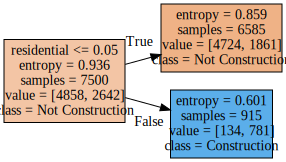

In [21]:
# Initialize and train a single split model
clf = TreeModel(max_depth=1, criterion='entropy').fit(X_train, y_train)
graph = Source(export_graphviz(clf, out_file=None, feature_names=features, filled=True, rotate=True,
                               class_names=['Not Construction', 'Construction']))
SVG(graph.pipe(format='svg'))

<span style="color:green"><font size=4>
So this is suggesting if the word "residential" is important to the document ie a high value, then that is most likely a constuction description. Gini is the evaulation of node purity, there is a useful link in the additional info section. It is not the only was to calculate node purity though and we could have chosen a different one if desired.
</span>

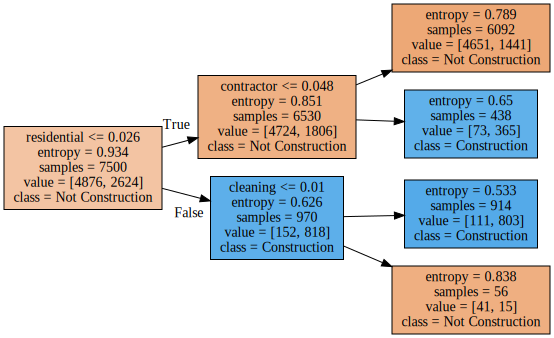

In [20]:
# Go deeper to a nother split
clf = TreeModel(max_depth=2, criterion='entropy').fit(X_train, y_train)
graph = Source(export_graphviz(clf, out_file=None, feature_names=features, filled=True, rotate=True,
                               class_names=['Not Construction', 'Construction']))
SVG(graph.pipe(format='svg'))

<span style="color:green"><font size=4>
The next split we are splitting on "contractor" and "cleaning". In the top split if "contractor" is important then it is most likely construction. In the bottom split if "cleaning" is important it is most likely not construction.

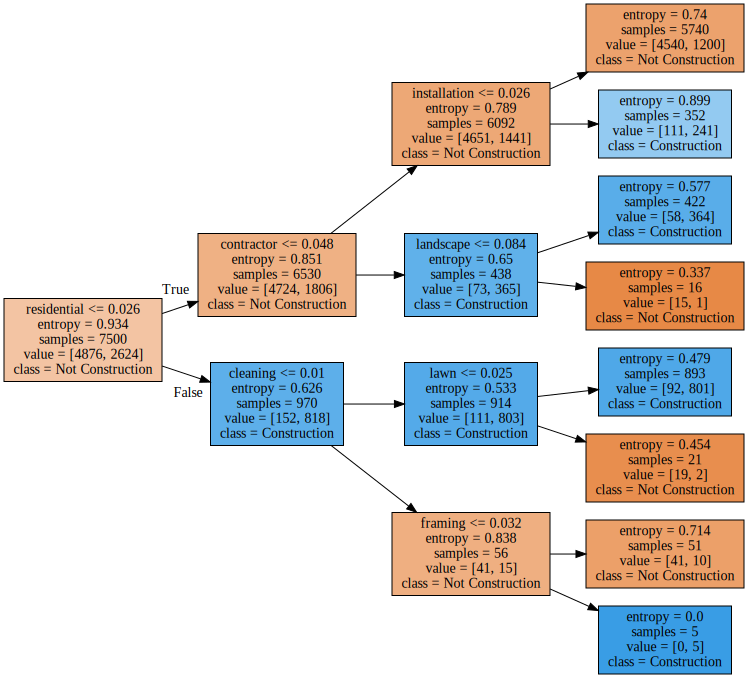

In [21]:
# Now going to a third split, this is getting a bit large
clf = TreeModel(max_depth=3, criterion='entropy').fit(X_train, y_train)
graph = Source(export_graphviz(clf, out_file=None, feature_names=features, filled=True, rotate=True,
                               class_names=['Not Construction', 'Construction']))
SVG(graph.pipe(format='svg'))

<span style="color:green"><font size=4>
Ok, this is already growing pretty large, but the words still seam reasonable
</span>

In [22]:
# No depth restrictions on this tree
clf = TreeModel(criterion='entropy').fit(X_train, y_train)

<a id='model_evaluate'></a>
## Evaluating Your Model
<span style="color:green"><font size=4>
OK, so we made a tree model, but now we need to see how good it is, and try to understand more about it. This takes many forms, the simplest one is to look at the accuracy of the model, but there are many metrics we could examine, accuracy is just the simplest.
    $$accuracy = \dfrac{correct}{total}$$
</span>

#### Accuracy of Model

In [23]:
from sklearn.metrics import accuracy_score
trained_predictions = clf.predict(X_train)
acc_train = accuracy_score(y_train, trained_predictions)
print(f"Training Data Accuracy: {acc_train*100:0.2f}%")

Training Data Accuracy: 99.25%


<span style="color:green"><font size=4>
Perfect Right? Well not so much. Trees are great at essentially going very deep and bringing each node to purity, so for the training data they essentially just memorize it. Even a simple linear model if made complex enough will be able to fit all of the data it sees. Remember that piece of data we didn't let the tree see though? Lets see how it does on that.
</span>

In [24]:
untrained_predictions = clf.predict(X_test)
acc_test = accuracy_score(y_test, untrained_predictions)
print(f"Testing Data Accuracy: {acc_test*100:0.2f}%")

Testing Data Accuracy: 88.68%


<span style="color:green"><font size=4>
This still is not too bad consider a fairly simple model. But it is also important to remember that we had a skewed data set so we are not getting the whole picture, lets see if we can see a little more of the picture.
</span>

#### Confusion Matrix of Model

In [25]:
# Use a nice plot found online - sklearn documentation has lots of this stuff
from sklearn.metrics import confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes, cmap=plt.cm.Blues):
    """
    Taken From http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-
               model-selection-plot-confusion-matrix-py    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title('Confusion matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

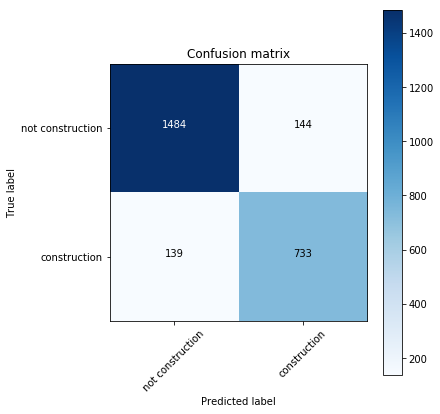

In [26]:
# Plot out resultant confusion matrix
cm = confusion_matrix(y_test, untrained_predictions)
fig, ax = plt.subplots(figsize=(6, 6))
plot_confusion_matrix(cm, ['not construction', 'construction'])

<span style="color:green"><font size=4>
Here we can see where our model is getting the wrong predictions, it is missing both classes a bit, although as a percentage it is getting construction wrong more than non construction
</span>

#### What influenced our model?

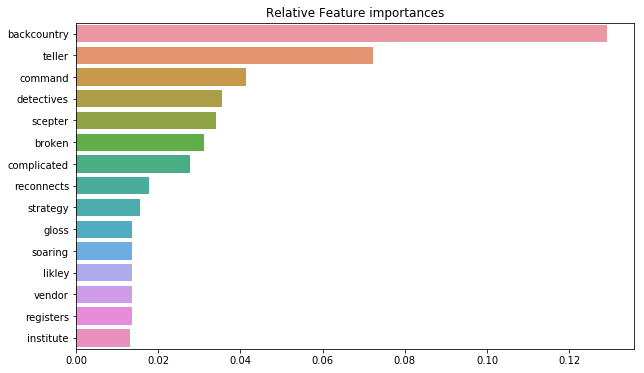

In [27]:
term_importances = list(zip(clf.feature_importances_, vectorizer.vocabulary_))
term_importances = sorted(term_importances, reverse=True)
plt.subplots(figsize=(10, 6))
plt.title("Relative Feature importances")
sns.barplot(y=[x[1] for x in term_importances[:15]], 
            x=[x[0] for x in term_importances[:15]],
            orient='h');

<span style="color:green"><font size=4>
According to our model these were the terms that resulted in the greatest purity increases, an exploration like this might make a little more sense if we are not dealing with text features. Something like this could be used to potentially prune the number of features going into the model to reduce its complexity a bit.
</span>

#### Exercise 5: Examine the least important features

In [28]:
pass

#### How deep is this un restricted tree?

In [29]:
max_depth = clf.tree_.max_depth
print(f"Max depth of tree: {max_depth} branches")

Max depth of tree: 449 branches


<span style="color:green"><font size=4>
That is a very deep tree, at some point it probably just fitting noise though, and can you imagine the tree diagram above. Maybe all this complexity isn't worth it.
</span>

<a id='overfitting'></a>
## Model Overfitting

<span style="color:green"><font size=4>
Our accuracy on the training data was 10% higher than that of the unseen testing data. This means that the model is fitting just to noise rather than a signal. Because of this it might not generalize as well to unseen data, and we have an overly complex model that might not be any better than a simpler one, potentially it could be worse. Lets take a quick look at this.
</span>

#### Iterate over all depths to see effect (Might not want to run this, will take quite a while)

In [30]:
error_train = []
error_test = []
for depth in range(1, max_depth):
    clf = TreeModel(max_depth=depth).fit(X_train, y_train)
    clf_min = TreeModel(min_samples_leaf=depth).fit(X_train, y_train)
    error_train.append(1 - accuracy_score(y_train, clf.predict(X_train)))
    error_test.append(1 - accuracy_score(y_test, clf.predict(X_test)))

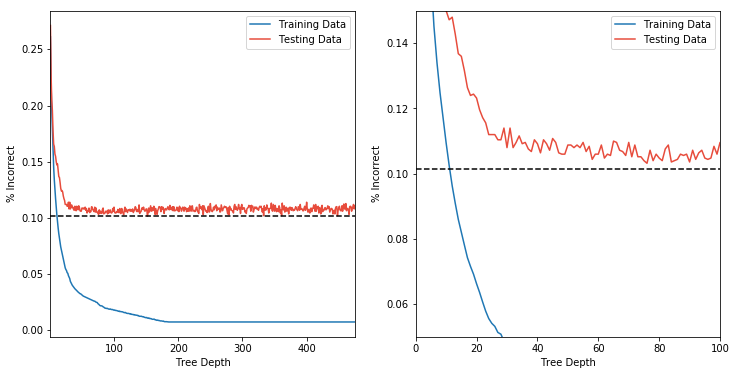

In [31]:
# Make a little area for these plots
fig, ax = plt.subplots(1, 2, figsize=(12,6))

# First plot - all data
sns.tsplot(data=error_train, time=range(1, max_depth), condition='Training Data', ax=ax[0])
sns.tsplot(data=error_test, time=range(1, max_depth), color="#e74c3c", condition='Testing Data', 
           ax=ax[0])
ax[0].axhline(y=min(error_test), color='k', ls="--")
ax[0].set_xlabel('Tree Depth')
ax[0].set_ylabel('% Incorrect')

# Second plot - zoom in
sns.tsplot(data=error_train, time=range(1, max_depth), condition='Training Data', ax=ax[1])
sns.tsplot(data=error_test, time=range(1, max_depth), color="#e74c3c", condition='Testing Data', 
           ax=ax[1])
ax[1].axhline(y=min(error_test), color='k', ls="--")
ax[1].set_xlabel('Tree Depth')
ax[1].set_ylabel('% Incorrect')
ax[1].set_xlim(0, 100)
ax[1].set_ylim(0.05, 0.15);

<span style="color:green"><font size=4>
So most of the complext model is in fact fitting noise, and makes the model do worse on data it has not seen before. So our final model should be the one that generalizes to data it has not seen, since this is how we will score the final kaggle model. These concepts, together called overfitting and the bias variance trade off are a very large topic, there is a link in the additional resources that has a deeper discussion on the topic</span>

#### Make a final classifier

In [32]:
best_depth = np.argmin(error_test) + 1
print(f"Min Error: {min(error_test): 0.3f}")
print(f"Depth: {best_depth}")

Min Error:  0.102
Depth: 152


In [33]:
# Make final model, note we only played with one of many tunable hyperparameters
final_clf = TreeModel(max_depth=best_depth).fit(X_train, y_train)

#### Experiment with your final classifier

In [34]:
# Make a fake business descr
desc = "I drive heavy wquipment to create homes"

# Explore what your business would be transformed to
my_business = pd.DataFrame([desc], columns=["desc"])
encoded = vectorizer.transform(my_business['desc'])
summarize_doc_transformation(my_business, 0, vectorizer, encoded)

# See the Final output
not_construction, construction = final_clf.predict_proba(encoded)[0]
print(f"\nThere is a {construction * 100: 0.2f}% chance you are construction")

DOCUMENT: 0
ORIGINAL DOCUMENT:
'I drive heavy wquipment to create homes'

NON ZERO VECTOR VALUES (Most to Least Important):
create:         0.634    heavy:          0.512    drive:          0.462    homes:          0.350    

TERMS w/ ZERO VALUE: 12,050
Sum of terms: 1.96

There is a  100.00% chance you are construction


<span style="color:green"><font size=4>
So, it is pretty easy to find pitfalls with our model. That is ok though, understanding its weaknesses is how we improve it. If you were to examine the whole tree of your final model it is pretty easy to see why it is failing, and also suggestive that this is not the best algorithm. Try tagging on the single word "residential" though and you get a different story.</span>

<a id='kaggle_submission'></a>
## Creating a kaggle submission

Firstly you will need to grab the official datasets from the box account. There is a train_df.pkl and a test_df.pkl. Here we will just apply our model to the test_df.pkl to create what a kaggle file would look like, you will have to some adjusting when working on the real kaggle problem

In [41]:
# load in the testing data
test_data_location = 'data/test_df.pkl'
with open(test_data_location, 'rb') as in_pickle:
    test_df = pickle.load(in_pickle)

In [54]:
# Pull of id for final submission
final = test_df['id'].to_frame()

# Add predictions to df
encoded = vectorizer.transform(test_df['desc_of_operations'])
final['pred_class'] = final_clf.predict(encoded)
final.to_csv('data/kaggle_submission.csv', index=False)

In [58]:
# note the ! this send command to shell, can be very helpful in notebooks
! head -n 10 data/kaggle_submission.csv

id,pred_class
996084,0
893938,0
893939,0
996091,0
886443,0
940892,1
942086,1
993537,1
993543,1


<a id='next'></a>
## What to do next

<span style="color:blue"><font size=4>
If you made it all the way through this then I thank you for taking the time, and I hope you learned something on the way. This is not the end though, this only touches on a tiny portion of topics realted to machine learning and text data. There are many more models to explore, they one presented in this tutorial is far from the best, but is simple to explain. If decisions treee interest you then maybe go explore random forests?. Other areas that you can explore would be how to choose hpyer paramters? Cross validation is not really discuessed here, but that is an area that is super important to any good model. </span>
    
<span style="color:blue"><font size=4> 
If this tfidf approach presented here seems like it loses alot of information, you are correct, and maybe you want to explore word embeddings? and maybe even neural nets?</span>
    
<span style="color:blue"><font size=4>
There are many flaws in the above approach, it is not meant to be perfect but illistrative, but if you see problems and want to make improvements that would be great, and you might get a better model becuase of it.</span>
    
<span style="color:blue"><font size=4>
Any feedback is also greatly appreciated</span> 
    
<span style="color:blue"><font size=4>
If you have not already done so head over the kaggle page and sign up, this will direct you where you can the full data sets and where to go for more resources</span> 

<a id='additional_resources'></a>
## Additional Resources- Random readings about above stuff
* Context managers: https://jeffknupp.com/blog/2016/03/07/python-with-context-managers/
* Dataframes: https://www.tutorialspoint.com/python_pandas/python_pandas_dataframe.htm
* Pickling: https://docs.python.org/3/library/pickle.html
* Good Matplotlib Tutorial: https://www.labri.fr/perso/nrougier/teaching/matplotlib/matplotlib.html
* Seaborn Documentation: https://seaborn.pydata.org/index.html
* Jupyter tips if you liked jupyter: https://www.dataquest.io/blog/jupyter-notebook-tips-tricks-shortcuts/
* Unerstanding Python String Formatting: https://dbader.org/blog/python-string-formatting
* Understanding TFIDF: http://www.tfidf.com/
* What are stop words?: https://en.wikipedia.org/wiki/Stop_words
* What is stemming and lemming?: https://marcobonzanini.com/2015/01/26/stemming-lemmatisation-and-pos-tagging-with-python-and-nltk/
* Official Documentation of SKlearn tfidf: http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html
* Understanding Decision Trees: https://towardsdatascience.com/decision-trees-understanding-explainable-ai-620fc37e598d
* Gini explanation: http://dni-institute.in/blogs/cart-decision-tree-gini-index-explained/
* Bias variance Tradeoff: http://scott.fortmann-roe.com/docs/BiasVariance.html

<a id='answers'></a>
## Possible Solutions to Execises

#### Exercise 1 Possible solution

In [45]:
# in progress

In [46]:
from string import punctuation